In [1]:
using Cubature

In [2]:
function R(n::Int64, m::Int64, ρ::Float64)
    if (n - m) % 2 != 0
        0
    else
        function summand(k)
            n = big(n)
            k = big(k)
            (-1)^k * factorial(n-k)/(factorial(k)*factorial(Int((n+m)/2) - k)*factorial(Int((n-m)/2) - k))*(ρ)^(n-2*k)
        end
        mapreduce(summand, +, Array(range(0, stop=Int((n-m)/2), step=1)))
    end
end

function Z(n, m, ρ, θ)
    if m < 0
        R(n, abs(m), ρ) * sin(abs(m) * θ)
    else
        R(n, m, ρ) * cos(m * θ)
    end
end

Z (generic function with 1 method)

In [3]:
σ1 = .1
σ2 = .1
function integrand(n, m)
    function rtn(coor)
        ρ = coor[1]
        θ = coor[2]
        x = ρ * cos(θ) - .25
        y = ρ * sin(θ) - .27
        Z(n, m, ρ, θ) * exp(-x^2/σ1^2 - y^2/σ2^2) * ρ
    end
    rtn
end

integrand (generic function with 1 method)

In [4]:
function neumann(m)
    if m == 0
        2
    else 
        1
    end
end
function cond_eval(n, m)
    if -n ≤ m ≤ n
        (2*n+2)/(π*neumann(m)) * hcubature(integrand(n, m), [0., 0.], [1., 2*π], maxevals=10000)[1]
    else
        0
    end
end

cond_eval (generic function with 1 method)

In [20]:
using Plots
gr()
maxn = 40
maxm = 15
data = hcat([[c[1] for c in [cond_eval(n, m) for n in range(0, maxn, step=1)]] for m in range(0, maxm, step=1)]...);

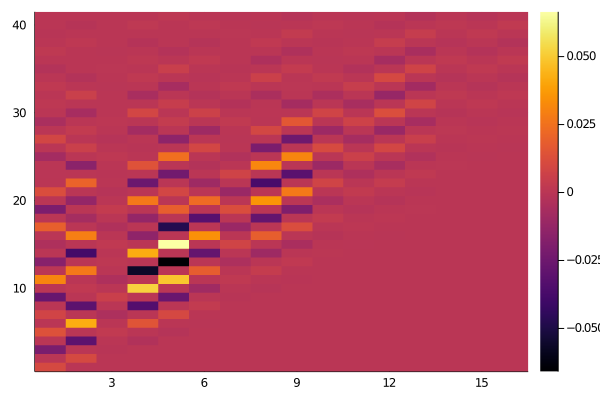

In [22]:
heatmap(data)

In [21]:
using Plots
gr()
dataodd = hcat([[c[1] for c in [cond_eval(n, -m) for n in range(0, maxn, step=1)]] for m in range(0, maxm, step=1)]...);

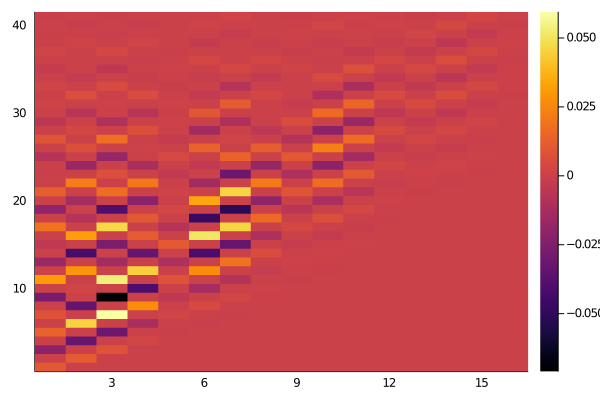

In [23]:
heatmap(dataodd)

In [24]:
function recon(ρ, ϕ)
    total = 0
    for (n,x) in enumerate(eachrow(data))
        for (m,y) in enumerate(x)
            if m ≤ n
                total += y*Z(n-1, m-1, ρ, ϕ)
            end
        end
    end
    for (n,x) in enumerate(eachrow(dataodd))
        for (m,y) in enumerate(x)
            if m ≤ n
                total += y*Z(n-1, -m+1, ρ, ϕ)
            end
        end
    end
    total
end


recon (generic function with 1 method)

In [25]:
function sample_across_unit_disk(f, discretization)
    x = y = Array(range(-1, 1, length=discretization))
    z = Array{typeof(f(0.,0.))}(UndefInitializer(), length(x), length(y))
    for (i, xx) in enumerate(x)
        for (j, yy) in enumerate(y)
            if xx^2 + yy^2 > 1
                if typeof(f(0.,0.)) == Tuple{Float64,Float64}
                    z[i, j] = (0.,0.)
                else
                    z[i, j] = 0.
                end
            else
                ρ = sqrt(xx^2 + yy^2)
                ϕ = atan(yy, xx)
                res = f(ρ, ϕ)
                z[i, j] = res
            end
        end
    end
    x, y, z
end


sample_across_unit_disk (generic function with 1 method)

In [32]:
num_points = 500
xx, yy, samples =  sample_across_unit_disk(recon, num_points)

([-1.0, -0.9959919839679359, -0.9919839679358717, -0.9879759519038076, -0.9839679358717435, -0.9799599198396793, -0.9759519038076152, -0.9719438877755511, -0.9679358717434869, -0.9639278557114228  …  0.9639278557114228, 0.9679358717434869, 0.9719438877755511, 0.9759519038076152, 0.9799599198396793, 0.9839679358717435, 0.9879759519038076, 0.9919839679358717, 0.9959919839679359, 1.0], [-1.0, -0.9959919839679359, -0.9919839679358717, -0.9879759519038076, -0.9839679358717435, -0.9799599198396793, -0.9759519038076152, -0.9719438877755511, -0.9679358717434869, -0.9639278557114228  …  0.9639278557114228, 0.9679358717434869, 0.9719438877755511, 0.9759519038076152, 0.9799599198396793, 0.9839679358717435, 0.9879759519038076, 0.9919839679358717, 0.9959919839679359, 1.0], BigFloat[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [33]:
function gaussian(ρ, θ)
    x = ρ*cos(θ) - .27
    y = ρ*sin(θ) - .25
    exp(-x^2/σ1^2-y^2/σ2^2)
end
xx, yy, samples2 =  sample_across_unit_disk(gaussian, num_points)

([-1.0, -0.9959919839679359, -0.9919839679358717, -0.9879759519038076, -0.9839679358717435, -0.9799599198396793, -0.9759519038076152, -0.9719438877755511, -0.9679358717434869, -0.9639278557114228  …  0.9639278557114228, 0.9679358717434869, 0.9719438877755511, 0.9759519038076152, 0.9799599198396793, 0.9839679358717435, 0.9879759519038076, 0.9919839679358717, 0.9959919839679359, 1.0], [-1.0, -0.9959919839679359, -0.9919839679358717, -0.9879759519038076, -0.9839679358717435, -0.9799599198396793, -0.9759519038076152, -0.9719438877755511, -0.9679358717434869, -0.9639278557114228  …  0.9639278557114228, 0.9679358717434869, 0.9719438877755511, 0.9759519038076152, 0.9799599198396793, 0.9839679358717435, 0.9879759519038076, 0.9919839679358717, 0.9959919839679359, 1.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

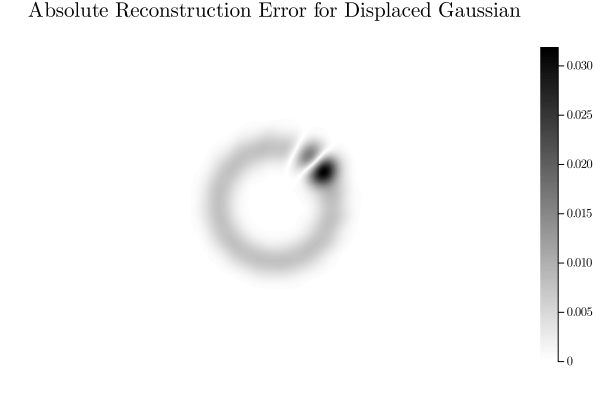

In [35]:
using LaTeXStrings
p = palette([:white, :black], 100)
plot(heatmap(xx, yy, .1*abs.(samples-samples2), c=p),aspectratio=true, legend=false, aspect_ratio = 1, axis=nothing, border=:none, title=L"\textrm{Absolute Reconstruction Error for Displaced Gaussian}", fontfamily="Computer Modern")